# Combinatorial Biases
Create figures and see how the measured assortativity of the dataset compares to those generated in null models.

In [52]:
import pandas as pd
from ast import literal_eval
import glob
import numpy as np
from scipy.stats import ttest_ind
from scipy.stats import norm

In [ ]:
def assortivity(G1, G2, multi):
    
    # Following Wagner(2015)
    # the probability that a link ends in an article of gender g2 given that it comes from an article of gender g1
    # with the probability that a link ends in an article of gender g2 regardless of the gender of its origin
    # positive values of L indicate increased connectivity from g1 to g2, and negative values the opposite

    # assumes how many men/women are mentioned matters!
    #multi = df.groupby('id').filter(lambda group: len(group) > 1)
    g1_ids = multi[multi['sex'] == G1]['id']
    from_g1 = multi[multi['id'].isin(set(g1_ids))]
    P_g2_fromg1 = from_g1[from_g1['sex'] == G2].shape[0]/ len(g1_ids) ## should this be a set or not?
    return(P_g2_fromg1)

def cis_assortivity(G, multi):
    # Assumes the NUMBER of connections for each ID doesn't matter
    g_ids = set(multi[multi['sex'] == G]['id'])
    ## see where 'female' in value counts is > 2
    subset = multi.groupby(['id','sex'])['NEL'].count().unstack()
    P_fromgtog = subset[subset[G] > 1.0].shape[0]/ len(g_ids)
    #P_g = subset[subset[G] > 0.0].shape[0]/ len(set(multi['id']))
    #print(P_fromgtog, P_g)
    return P_fromgtog

def get_pvalue(obs,x,p, ascending=True):
    for i, value in enumerate(x):
        if value > obs:
            return p[i-1]

In [53]:
# Colours
WOMEN = "#ff876d"
WOMEN_POS = "#ffcea8"
WOMEN_NEG = "#cb4d36"
MEN = "#009ce4"
MEN_POS = "#76efff"#"#b8e1ff"
MEN_NEG = "#056497"
ACCENT = "#d2518f"
ACCENT2 = "#987ad3"

In [56]:
# Collect Dataset
dfs = []
for file in glob.glob("C:/Users/vanki/201*.csv"): ## Collect dataset
    dfs.append(pd.read_csv(file))
    
# # Remove any corruptions in dataset
# df = pd.concat(dfs).drop(columns=["Unnamed: 0"])
# df.dropna(subset=['Adjectives'], inplace=True) # somekind of mistake

df = df[df['sex'].isin(['male','female'])]

In [62]:
# # To look at partisan data only
# left = ['Liberal', 'SocialDemocracy', 'socialism', 'alltheleft', 'neoliberal', 'democrats']
# right = ['Libertarian', 'Conservative', 'Republican']
# alt_right = ['The_Donald']

# full_df = df
# maps = {}
# for sr in left:
#     maps[sr] = 'left'
# for sr in right:
#     maps[sr] = 'right'
# maps['The_Donald'] = 'alt_right'
# df['group'] = df['subreddit'].map(maps)
# df.dropna(subset=['group'], inplace=True)

In [4]:
# Limit to only comments mentioning more than one entity
multi = df.groupby('id').filter(lambda group: len(group) > 1)

print("Total unique comments", len(multi['id'].unique()))
print("Total DF size", multi.shape[0])

In [ ]:
print('Male to female', assortivity('male','female', multi))
print('Female to male', assortivity('female','male', multi))
print('Female', cis_assortivity("female",multi))
print('Male', cis_assortivity("male",multi))

In [ ]:
# This is essentially how the null models are created
# shuffle = multi['id'].sample(frac=1).values

# new = multi[['id','NEL','sex']].copy()
# new['id'] = shuffle
# print('Male to female', assortivity('male','female', new))
# print('Female to male', assortivity('female','male', new))
# print('Female to female', cis_assortivity('female', new))
# print('male to male', cis_assortivity('male', new))

In [ ]:
# Look at null model results
import matplotlib.pyplot as plt
with open("male_male.txt", "r+") as file:
    raw_mm = file.readlines()
    mm = [float(x[:-2]) for x in raw_mm]
    
with open("female_male.txt", "r+") as file:
    raw_fm = file.readlines()
    fm = [float(x[:-2]) for x in raw_fm]

with open("male_female.txt", "r+") as file:
    raw_mf = file.readlines()
    mf = [float(x[:-2]) for x in raw_mf]

with open("female_female.txt", "r+") as file:
    raw_ff = file.readlines()
    ff = [float(x[:-2]) for x in raw_ff]

In [ ]:
plt.title("Additional women mentioned per female-entity containing comment")
mu, std = norm.fit(ff)
plt.hist(ff, alpha=0.5,density=True, color='pink', hatch='....', edgecolor='hotpink', fill=True)
plt.axvline(cis_assortivity('female',multi), color='black')
# Plot the PDF.
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'grey', linewidth=2)
# plt.axvline(cis_assortivity('female',multi[multi['subreddit'].isin(left)]), color='blue', label="Left")
# plt.axvline(cis_assortivity('female',multi[multi['subreddit'].isin(right)]), color='red', label="Right")
# plt.axvline(cis_assortivity('female',multi[multi['subreddit'].isin(alt_right)]), color='orange', label="Alt-right")
# plt.legend()
plt.yticks([])
plt.show()
print(get_pvalue(cis_assortivity('female',multi),x,p))

In [ ]:
plt.title("Additional men mentioned per male-entity containing comment")
mu, std = norm.fit(mm)
plt.hist(mm, alpha=0.5,density=True, color='lightblue', edgecolor='blue', hatch='....')
plt.axvline(cis_assortivity('male',multi), color='black')
# Plot the PDF.
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'grey', linewidth=2)
print(get_pvalue(cis_assortivity('male',multi),x,p))
# plt.axvline(cis_assortivity('male',multi[multi['subreddit'].isin(left)]), color='blue', label="Left")
# plt.axvline(cis_assortivity('male',multi[multi['subreddit'].isin(right)]), color='red', label="Right")
# plt.axvline(cis_assortivity('male',multi[multi['subreddit'].isin(alt_right)]), color='orange', label="Alt-right")
# plt.legend()
plt.yticks([])
plt.show()

In [ ]:
plt.title("Men mentioned per female-entity containing comment")
mu, std = norm.fit(fm)
plt.hist(fm, alpha=0.5,density=True, color='pink', edgecolor='blue', hatch='..')
plt.axvline(assortivity('female','male',multi), color='black')
# Plot the PDF.
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'grey', linewidth=2)
print(get_pvalue(assortivity('female','male',multi),x,p))

# plt.axvline(assortivity('female','male',multi[multi['subreddit'].isin(left)]), color='blue', label="Left")
# plt.axvline(assortivity('female','male',multi[multi['subreddit'].isin(right)]), color='red', label="Right")
# plt.axvline(assortivity('female','male',multi[multi['subreddit'].isin(alt_right)]), color='orange', label="Alt-right")
plt.legend()
plt.yticks([])
plt.show()

# p<10**-4

In [ ]:
plt.title("Women mentioned per male-entity containing comment")
mu, std = norm.fit(mf)
plt.hist(mf, alpha=0.5,density=True, color='lightblue', edgecolor='hotpink', hatch='..')
plt.axvline(assortivity('male','female',multi), color='black')
# Plot the PDF.
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'grey', linewidth=2)
print(get_pvalue(assortivity('male','female',multi),x,p))
plt.yticks([])
plt.show()

In [ ]:
fig, ax = plt.subplots(2,2, figsize=(10,7))
fig.suptitle("Recorded $\mathregular{L(g_{given},g_{add})}$ against null model distributions", size=16)

#ax[0][0].title("Women, given woman-containing")
mu, std = norm.fit(ff)
ax[0][0].hist(ff, alpha=0.5,density=True, color=WOMEN, hatch='..', edgecolor=WOMEN_NEG, fill=True)
ax[0][0].axvline(ff_rec, color=ACCENT)
# Plot the PDF.
xmin, xmax = ax[0][0].get_xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
ax[0][0].set_yticks([])
ax[0][0].set_ylabel("Additional female entities", size=12, color=WOMEN_NEG)
ax[0][0].set_title("Given a female entity", size=12, color=WOMEN)
ax[0][0].plot(x, p, 'grey', linewidth=2, alpha=0.8)
print("female to female", get_pvalue(ff_rec,x,p))

mu, std = norm.fit(mf)
ax[0][1].hist(mf, alpha=0.5,density=True, color=MEN, edgecolor=WOMEN_NEG, hatch='..')
ax[0][1].axvline(mf_rec, color=ACCENT)
# Plot the PDF.
xmin, xmax = ax[0][1].get_xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
ax[0][1].set_yticks([])
ax[0][1].set_title("Given a male entity", size=12,color=MEN, alpha=0.5)
ax[0][1].plot(x, p, 'grey', linewidth=2, alpha=0.8)
print("male to female" ,get_pvalue(mf_rec,x,p))

mu, std = norm.fit(fm)
ax[1][0].hist(fm, alpha=0.5,density=True, color=WOMEN, edgecolor=MEN_NEG, hatch='..')
ax[1][0].axvline(fm_rec, color=ACCENT)
# Plot the PDF.
xmin, xmax = ax[1][0].get_xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
ax[1][0].set_xticks(np.arange(xmin,xmax,0.005))
ax[1][0].set_yticks([])
ax[1][0].set_ylabel("Additional male entities", size=12, color=MEN_NEG)
ax[1][0].plot(x, p, 'grey', linewidth=2, alpha=0.8)
print("female to male" , get_pvalue(fm_rec,x,p))

mu, std = norm.fit(mm)
ax[1][1].hist(mm, alpha=0.5,density=True, color=MEN, edgecolor=MEN_NEG, hatch='..')
ax[1][1].axvline(mm_rec, color=ACCENT)
# Plot the PDF.
xmin, xmax = ax[1][1].get_xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
ax[1][1].set_yticks([])
ax[1][1].plot(x, p, 'grey', linewidth=2, alpha=0.8)
print("male to male" , get_pvalue(mm_rec,x,p))


# plt.axvline(cis_assortivity('female',multi[multi['subreddit'].isin(left)]), color='blue', label="Left")
# plt.axvline(cis_assortivity('female',multi[multi['subreddit'].isin(right)]), color='red', label="Right")
# plt.axvline(cis_assortivity('female',multi[multi['subreddit'].isin(alt_right)]), color='orange', label="Alt-right")
plt.savefig("null_models.png")
plt.show()

In [ ]:
# Can I put them all in the same graph?
plt.xlim(0,5)
plt.title("Number G2 entities mentioned in a comment, given at least one mention of G1")
plt.scatter(1, cis_assortivity('male',multi)+1, color='black', marker = 'o', label='Observed value')
plt.scatter(1, np.mean(mm)+1, color='lightgrey', marker = '*', label='Null value')
plt.scatter(2, assortivity('male','female',multi), color='black', marker = 'o')
plt.scatter(2, np.mean(mf), color='lightgrey', marker = '*')
plt.scatter(3, assortivity('female','male',multi), color='black', marker = 'o')
plt.scatter(3, np.mean(fm), color='lightgrey', marker = '*')
plt.scatter(4, cis_assortivity('female',multi)+1, color='black', marker = 'o')
plt.scatter(4, np.mean(ff)+1, color='lightgrey', marker = '*')
plt.xticks(range(6), ['','Male\n:\nmale', 'Male\n:\nfemale', 'Female\n:\nmale', 'Female\n:\nfemale', ''])
plt.legend()
plt.show()

In [80]:
fem_ratio = multi[multi['sex'] == 'female'].shape[0]/multi.shape[0]
men_ratio = multi[multi['sex'] == 'male'].shape[0]/multi.shape[0]

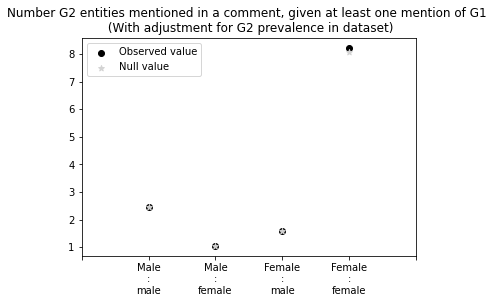

In [85]:
plt.xlim(0,5)
plt.title("Number G2 entities mentioned in a comment, given at least one mention of G1 \n (With adjustment for G2 prevalence in dataset)")
plt.scatter(1, (cis_assortivity('male',multi)+1)/men_ratio, color='black', marker = 'o', label='Observed value')
plt.scatter(1, (np.mean(mm)+1)/men_ratio, color='lightgrey', marker = '*', label='Null value')
plt.scatter(2, (assortivity('male','female',multi))/fem_ratio, color='black', marker = 'o')
plt.scatter(2, (np.mean(mf))/fem_ratio, color='lightgrey', marker = '*')
plt.scatter(3, (assortivity('female','male',multi))/men_ratio, color='black', marker = 'o')
plt.scatter(3, (np.mean(fm))/men_ratio, color='lightgrey', marker = '*')
plt.scatter(4, (cis_assortivity('female',multi)+1)/fem_ratio, color='black', marker = 'o')
plt.scatter(4, (np.mean(ff)+1)/fem_ratio, color='lightgrey', marker = '*')
plt.xticks(range(6), ['','Male\n:\nmale', 'Male\n:\nfemale', 'Female\n:\nmale', 'Female\n:\nfemale', ''])
plt.legend()
plt.show()

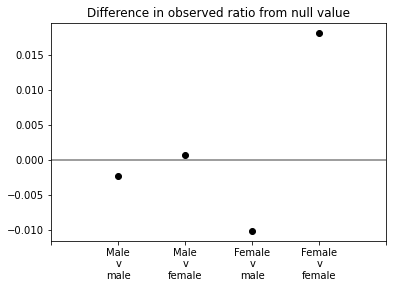

In [95]:
plt.xlim(0,5)
plt.title("Difference in observed ratio from null value")
plt.axhline(0, color='grey')
plt.scatter(1, (-np.mean(mm) + cis_assortivity('male',multi)), color='black', marker = 'o')
plt.scatter(2, (-np.mean(mf) + assortivity('male','female',multi)), color='black', marker = 'o')
plt.scatter(3, (-np.mean(fm) + assortivity('female','male',multi)), color='black', marker = 'o')
plt.scatter(4, (-np.mean(ff) + cis_assortivity('female',multi)), color='black', marker = 'o')
plt.xticks(range(6), ['','Male\nv\nmale', 'Male\nv\nfemale', 'Female\nv\nmale', 'Female\nv\nfemale', ''])
#plt.legend()
plt.show()

## Cross-partisan comparison

In [12]:
left = ['Liberal', 'SocialDemocracy', 'socialism', 'alltheleft', 'neoliberal', 'democrats']
right = ['Libertarian', 'Conservative', 'Republican']
alt_right = ['The_Donald']

In [14]:
for i,group in enumerate([left, right, alt_right]):
    
    mf_rec = assortivity('male','female', multi[multi['subreddit'].isin(group)])
    fm_rec = assortivity('female','male', multi[multi['subreddit'].isin(group)])
    mm_rec = cis_assortivity('male', multi[multi['subreddit'].isin(group)])
    ff_rec = cis_assortivity('female', multi[multi['subreddit'].isin(group)])
    print(group)
    print('male, male', mm_rec)
    print ('male, female', mf_rec)
    print ('female, male', fm_rec)
    print('female,felame', ff_rec)
    print()

['Liberal', 'SocialDemocracy', 'socialism', 'alltheleft', 'neoliberal', 'democrats']
male, male 1.169872053872054
male, female 0.16962008031629974
female, male 1.4544513111742108
female,felame 0.17544272980720146

['Libertarian', 'Conservative', 'Republican']
male, male 1.1899835311008826
male, female 0.13568963190065753
female, male 1.4232109815396532
female,felame 0.1592258193245872

['The_Donald']
male, male 1.0270201193620274
male, female 0.17555921285481701
female, male 1.2337031591142005
female,felame 0.1661275866100308



### Visualizations

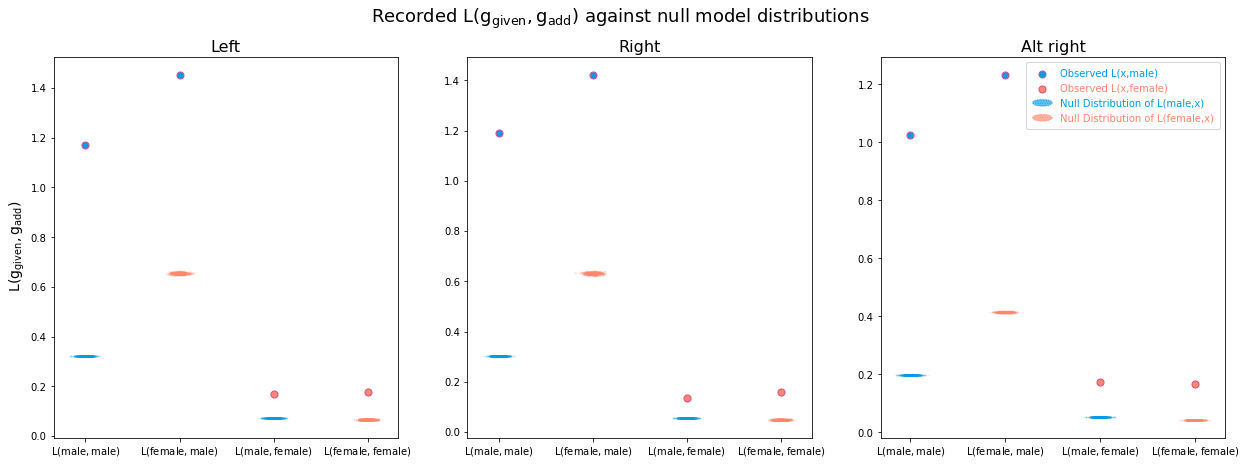

In [81]:
from random import sample
import matplotlib.patches as mpatches
from matplotlib.legend_handler import HandlerPatch

import matplotlib as mpl
mpl.rcParams['text.color'] = 'k'
mpl.rcParams['xtick.color'] = 'k'

class HandlerEllipse(HandlerPatch):
    def create_artists(self, legend, orig_handle,
                       xdescent, ydescent, width, height, fontsize, trans):
        center = 0.5 * width - 0.5 * xdescent, 0.5 * height - 0.5 * ydescent
        p = mpatches.Ellipse(xy=center, width=width + xdescent,
                             height=height + ydescent)
        self.update_prop(p, orig_handle, legend)
        p.set_transform(trans)
        return [p]

path = "results/null/cross/"

SAMPLE = 1000       
        
fig, ax = plt.subplots(1, 3, figsize=(21,7))
fig.suptitle("Recorded $\mathregular{L(g_{given},g_{add})}$ against null model distributions", size=18)
names = ['Left', 'Right', 'Alt right']
file_names = ['left','right','alt_right']

distri_colors = [MEN,WOMEN,MEN,WOMEN]
obs_colors = [MEN, MEN, WOMEN, WOMEN]
for i,group in enumerate([left, right, alt_right]):
    
    mf_rec = assortivity('male','female', multi[multi['subreddit'].isin(group)])
    fm_rec = assortivity('female','male', multi[multi['subreddit'].isin(group)])
    mm_rec = cis_assortivity('male', multi[multi['subreddit'].isin(group)])
    ff_rec = cis_assortivity('female', multi[multi['subreddit'].isin(group)])
    with open(path + file_names[i] + "/male_male.txt", "r+") as file:
        raw_mm = file.readlines()
        mm = [float(x[:-2]) for x in raw_mm]

    with open(path + file_names[i] + "/female_male.txt", "r+") as file:
        raw_fm = file.readlines()
        fm = [float(x[:-2]) for x in raw_fm]

    with open(path + file_names[i] + "/male_female.txt", "r+") as file:
        raw_mf = file.readlines()
        mf = [float(x[:-2]) for x in raw_mf]

    with open(path + file_names[i] + "/female_female.txt", "r+") as file:
        raw_ff = file.readlines()
        ff = [float(x[:-2]) for x in raw_ff]
        
    obs = [mm_rec, fm_rec, mf_rec, ff_rec]
    distri = [mm, fm, mf, ff]
    ax[i].set_title(names[i], size=16)
    loc = 1
    for j in range(4):
        ax[i].scatter((np.random.normal(0,0.05,SAMPLE)+[loc]*SAMPLE), sample(distri[j],SAMPLE), s=1, color=distri_colors[j], alpha=0.1)
        ax[i].scatter(loc, obs[j], s=50,color=obs_colors[j], edgecolor=ACCENT)
        loc += 1
    ax[i].set_xticks([1,2,3,4])
    ax[i].set_xticklabels(['$\mathregular{L(male,male)}$','$\mathregular{L(female,male)}$','$\mathregular{L(male,female)}$', '$\mathregular{L(female,female)}$'])

ax[0].set_ylabel(' $\mathregular{L(g_{given},g_{add})}$', size=14)

labels = [
    plt.scatter([],[], marker="o", s=50, color=MEN, edgecolor=ACCENT, label="Observed L(x,male)"),
    plt.scatter([],[], marker="o", s=50, color=WOMEN, edgecolor=ACCENT, label="Observed L(x,female)"),
    mpatches.Circle((0.5, 0.5), 0, facecolor=MEN, alpha=0.6,
                    edgecolor=MEN, linestyle=":", hatch='.....', label='Null Distribution of L(male,x)'),
    mpatches.Circle((0.5, 0.5), 0, facecolor=WOMEN, alpha=0.6,
                    edgecolor=WOMEN, linestyle=":", hatch='.....', label='Null Distribution of L(female,x)')
]
l = plt.legend(handles=labels,handler_map={mpatches.Circle: HandlerEllipse()}, loc="upper right",borderpad=0.6)

i = 0
for text in l.get_texts():
    text.set_color(distri_colors[i])
    i+= 1

plt.show()

female to female 0.0
male to female 0.0
female to male 0.0
male to male 0.0


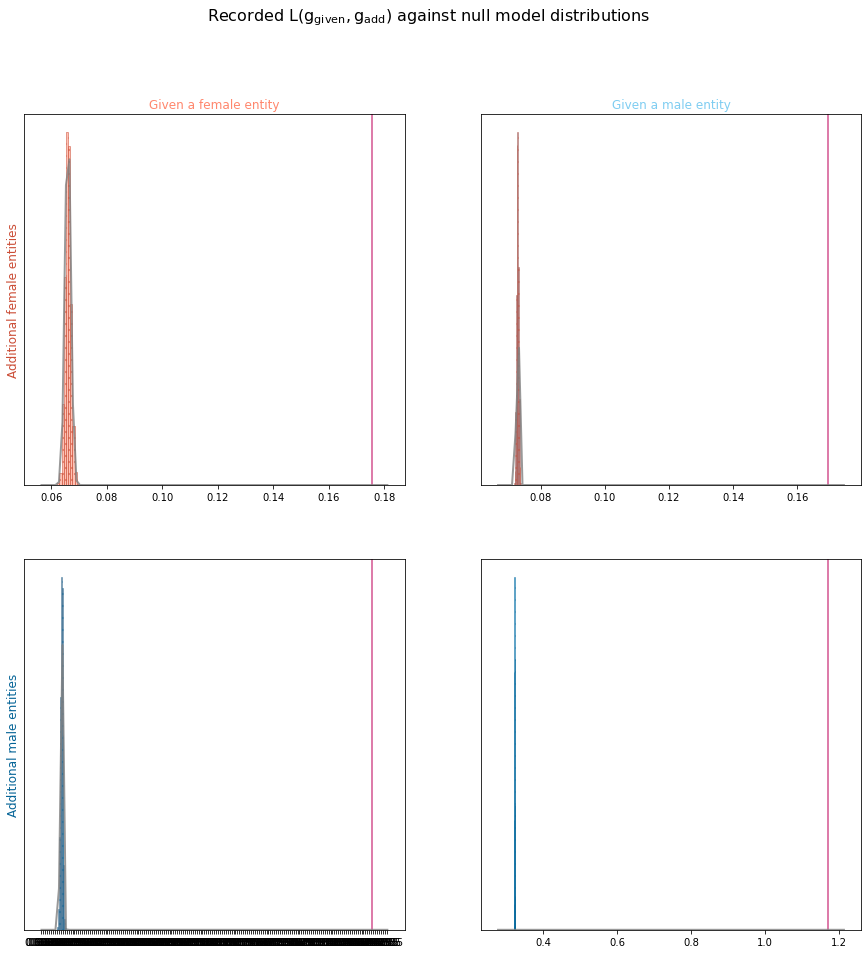

female to female 0.0
male to female 0.0
female to male 0.0
male to male 0.0


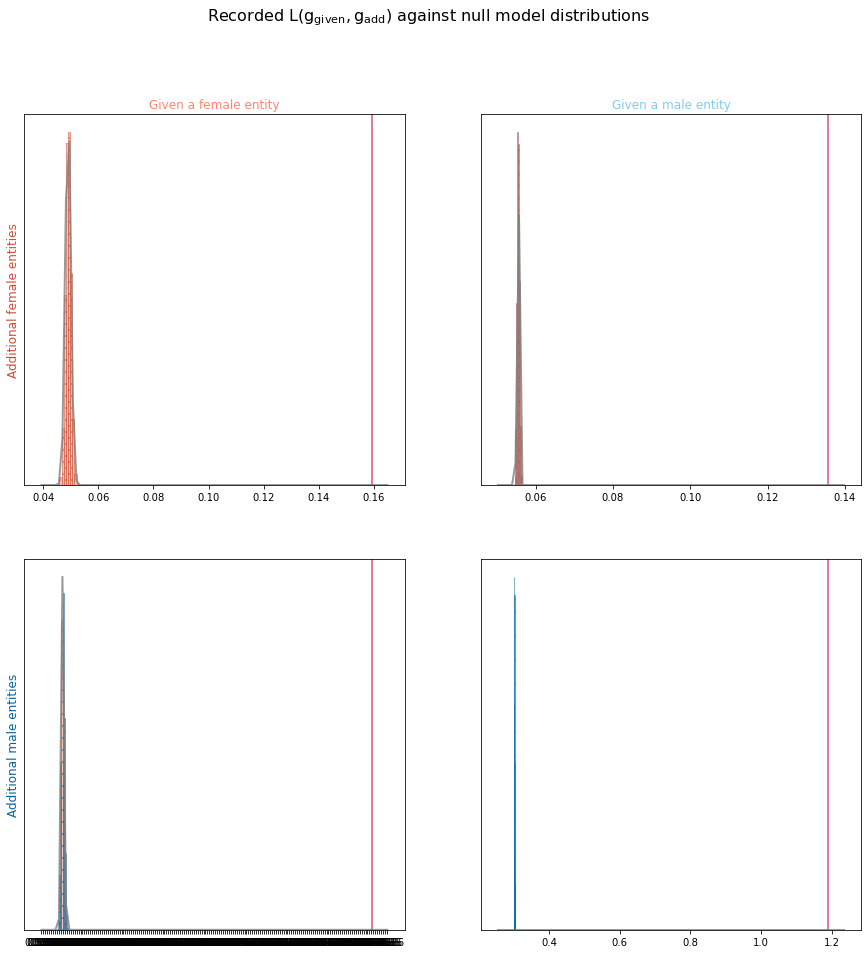

female to female 0.0
male to female 0.0
female to male 0.0
male to male 0.0


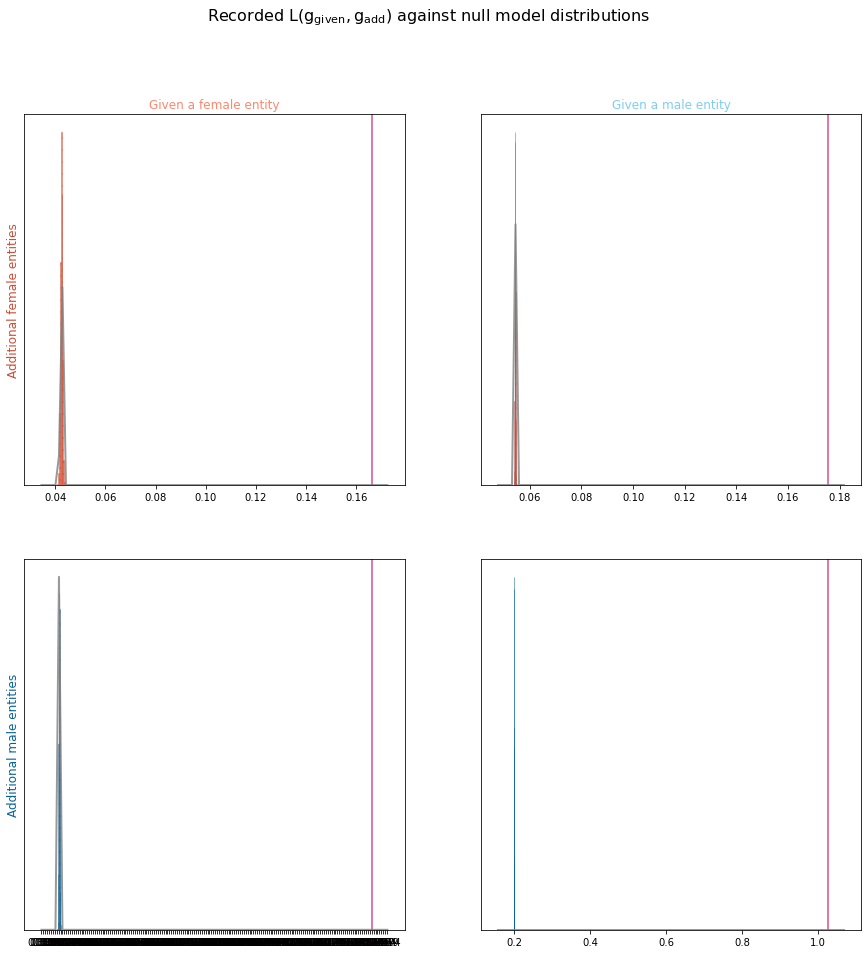

In [213]:
path = "results/null/cross/"
fig.suptitle('Cumulative CDFs of Entity In-degree Across Partisanship', size=16)

def get_pvalue(obs,x,p, ascending=True):
    for i, value in enumerate(x):
        if value > obs:
            return p[i-1]
        
for i,group in enumerate(['left', 'right', 'alt_right']):
    
    mf_rec = assortivity('male','female', multi[multi['group'] == group])
    fm_rec = assortivity('female','male', multi[multi['group'] == group])
    mm_rec = cis_assortivity('male', multi[multi['group'] == group])
    ff_rec = cis_assortivity('female', multi[multi['group'] == group])
    with open(path + group + "/male_male.txt", "r+") as file:
        raw_mm = file.readlines()
        mm = [float(x[:-2]) for x in raw_mm]

    with open(path + group + "/female_male.txt", "r+") as file:
        raw_fm = file.readlines()
        fm = [float(x[:-2]) for x in raw_fm]

    with open(path + group + "/male_female.txt", "r+") as file:
        raw_mf = file.readlines()
        mf = [float(x[:-2]) for x in raw_mf]

    with open(path + group + "/female_female.txt", "r+") as file:
        raw_ff = file.readlines()
        ff = [float(x[:-2]) for x in raw_ff]
        
    fig, ax = plt.subplots(2, 2, figsize=(15,15))
    fig.suptitle("Recorded $\mathregular{L(g_{given},g_{add})}$ against null model distributions", size=16)

    #ax[0][0].title("Women, given woman-containing")
    mu, std = norm.fit(ff)
    ax[0][0].hist(ff, alpha=0.5,density=True, color=WOMEN, hatch='..', edgecolor=WOMEN_NEG, fill=True)
    ax[0][0].axvline(ff_rec, color=ACCENT)
    # Plot the PDF.
    xmin, xmax = ax[0][0].get_xlim()
    x = np.linspace(xmin, xmax, 100)
    p = norm.pdf(x, mu, std)
    ax[0][0].set_yticks([])
    ax[0][0].set_ylabel("Additional female entities", size=12, color=WOMEN_NEG)
    ax[0][0].set_title("Given a female entity", size=12, color=WOMEN)
    ax[0][0].plot(x, p, 'grey', linewidth=2, alpha=0.8)
    print("female to female", get_pvalue(ff_rec,x,p))

    mu, std = norm.fit(mf)
    ax[0][1].hist(mf, alpha=0.5,density=True, color=MEN, edgecolor=WOMEN_NEG, hatch='..')
    ax[0][1].axvline(mf_rec, color=ACCENT)
    # Plot the PDF.
    xmin, xmax = ax[0][1].get_xlim()
    x = np.linspace(xmin, xmax, 100)
    p = norm.pdf(x, mu, std)
    ax[0][1].set_yticks([])
    ax[0][1].set_title("Given a male entity", size=12,color=MEN, alpha=0.5)
    ax[0][1].plot(x, p, 'grey', linewidth=2, alpha=0.8)
    print("male to female" ,get_pvalue(mf_rec,x,p))

    mu, std = norm.fit(fm)
    ax[1][0].hist(fm, alpha=0.5,density=True, color=WOMEN, edgecolor=MEN_NEG, hatch='..')
    ax[1][0].axvline(fm_rec, color=ACCENT)
    # Plot the PDF.
    xmin, xmax = ax[1][0].get_xlim()
    x = np.linspace(xmin, xmax, 100)
    p = norm.pdf(x, mu, std)
    ax[1][0].set_xticks(np.arange(xmin,xmax,0.005))
    ax[1][0].set_yticks([])
    ax[1][0].set_ylabel("Additional male entities", size=12, color=MEN_NEG)
    ax[1][0].plot(x, p, 'grey', linewidth=2, alpha=0.8)
    print("female to male" , get_pvalue(fm_rec,x,p))

    mu, std = norm.fit(mm)
    ax[1][1].hist(mm, alpha=0.5,density=True, color=MEN, edgecolor=MEN_NEG, hatch='..')
    ax[1][1].axvline(mm_rec, color=ACCENT)
    # Plot the PDF.
    xmin, xmax = ax[1][1].get_xlim()
    x = np.linspace(xmin, xmax, 100)
    p = norm.pdf(x, mu, std)
    ax[1][1].set_yticks([])
    ax[1][1].plot(x, p, 'grey', linewidth=2, alpha=0.8)
    print("male to male" , get_pvalue(mm_rec,x,p))
    plt.show()